In [ ]:
import numpy as np
from scipy.linalg import sqrtm, inv

### Одномерный случай

$$y_i = x_i * \theta + \epsilon_i$$

In [ ]:
N = 1000
theta_true = np.random.randn(1)
X = np.random.randn(N) + 1.0
y = X * theta_true

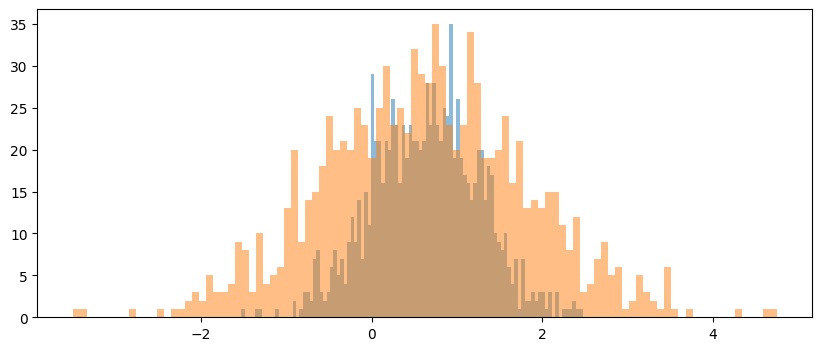

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(y, bins=100, alpha=0.5)
y = y + 1.0 * np.random.randn(N)
plt.hist(y, bins=100, alpha=0.5)
plt.show()

In [ ]:
theta_true

array([0.62396023])

In [ ]:
(y.mean() / X.mean() - theta_true)

array([-0.01154655])

In [ ]:
((y / X).mean() - theta_true)

array([-0.128358])

In [ ]:
(y.mean() / 1.0 - theta_true)

array([-0.00224282])

### Простой случай с матрицей ковариации 2х2

In [ ]:
N = 1000
theta_true = np.random.randn(2)

sigma_half = np.random.randn(2, 2)
sigma_true = sigma_half.T @ sigma_half
X_samples = np.random.default_rng().multivariate_normal(np.zeros(2), sigma_true, N, check_valid="warn")

y = []
xy = np.zeros(2)
for i in range(N):
  y.append(np.sum(X_samples[i] * theta_true))
  xy += X_samples[i] * y[i]
xy /= N

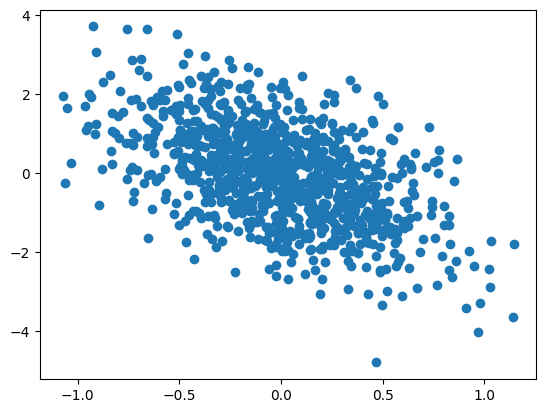

In [ ]:
plt.scatter(X_samples[:, 0], X_samples[:, 1])
plt.show()

In [ ]:
sigma_base = np.zeros((2, 2))
for i in range(N):
  vec_x = X_samples[i]
  sigma_base += vec_x[:, None] @ vec_x[None, :]
sigma_base /= N

In [ ]:
sigma_true @ theta_true - xy

array([-0.12530498,  0.0985931 ])

In [ ]:
sigma_base @ theta_true - xy

array([-0.12591029,  0.08763953])

In [ ]:
theta1, _, _, _ = np.linalg.lstsq(sigma_true, xy, rcond=None)
theta2, _, _, _ = np.linalg.lstsq(sigma_base, xy, rcond=None)
print(theta1 - theta_true)
print(theta2 - theta_true)

[0.94220821 0.07251032]
[1.02022443 0.10106994]


### Основной код

In [ ]:
def generate_reg_data(q, p, N, K_sum):
  theta_true = np.random.randn(p, q)
  theta_true /= np.linalg.norm(theta_true)
  A_list = [np.random.randn(q, q) for k in range(K_sum)]
  B_list = [np.random.randn(p, p) for k in range(K_sum)]
  sigma_true = np.zeros((p * q, p * q))
  for k in range(K_sum):
    A = A_list[k]
    B = B_list[k]
    sigma_true += np.kron(A @ A.T, B @ B.T)
  sigma_norm = np.linalg.norm(sigma_true)
  sigma_true /= sigma_norm

  X_samples = np.random.default_rng().multivariate_normal(np.zeros(p * q), sigma_true, N, check_valid="warn")
  #print(X_samples.shape)
  #print(X_samples.mean(axis=0))
  X = []
  y = []
  for i in range(N):
    #Z = np.random.randn(p, q)
    #A_sum = np.zeros((q, q))
    #B_sum = np.zeros((p, p))
    #for k in range(K_sum):
    #  A = A_list[k]
    #  B = B_list[k]
    #  A_sum += A
    #  B_sum += B
    #cur_X = B_sum @ Z @ A_sum.T
    cur_X = X_samples[i].reshape((p, q), order='F')

    X.append(cur_X)
    y.append(np.sum(X[-1] * theta_true))

  return X, y, theta_true, sigma_true

In [ ]:
X, y, theta_true, sigma_true = generate_reg_data(3, 30, N=1000, K_sum=5)

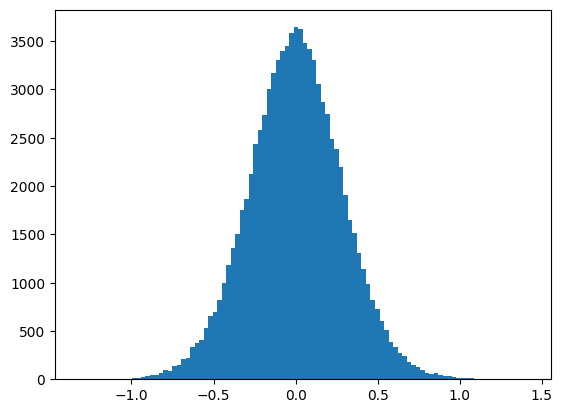

In [ ]:
plt.hist(np.array(X).reshape(-1), bins=100)
plt.show()

In [ ]:
test_A = np.kron(np.array([[1, 2], [3, 4]]), np.arange(9).reshape((3, 3)))
test_A

array([[ 0,  1,  2,  0,  2,  4],
       [ 3,  4,  5,  6,  8, 10],
       [ 6,  7,  8, 12, 14, 16],
       [ 0,  3,  6,  0,  4,  8],
       [ 9, 12, 15, 12, 16, 20],
       [18, 21, 24, 24, 28, 32]])

In [ ]:
def R_operator(A, p, q):
  B = np.zeros((q * q, p * p))
  for i in range(q):
    for j in range(q):
      M = A[i * p:(i + 1) * p, j * p:(j + 1) * p]
      B[j * q + i, :] = M.reshape(-1, order='F')
  return B

def R_inv_operator(B, p, q):
  A = np.zeros((p * q, p * q))
  for i in range(q):
    for j in range(q):
      M = B[j * q + i, :].reshape((p, p), order='F')
      A[i * p:(i + 1) * p, j * p:(j + 1) * p] = M
  return A

In [ ]:
test_B = R_operator(test_A, 3, 2)
print(test_B)
pred_A = R_inv_operator(test_B, 3, 2)
print(pred_A)
print(np.all(pred_A == test_A))

[[ 0.  3.  6.  1.  4.  7.  2.  5.  8.]
 [ 0.  9. 18.  3. 12. 21.  6. 15. 24.]
 [ 0.  6. 12.  2.  8. 14.  4. 10. 16.]
 [ 0. 12. 24.  4. 16. 28.  8. 20. 32.]]
[[ 0.  1.  2.  0.  2.  4.]
 [ 3.  4.  5.  6.  8. 10.]
 [ 6.  7.  8. 12. 14. 16.]
 [ 0.  3.  6.  0.  4.  8.]
 [ 9. 12. 15. 12. 16. 20.]
 [18. 21. 24. 24. 28. 32.]]
True


In [ ]:
def get_theta_by_sigma(X, y, lambd, sigma):
  p, q = X[0].shape
  N = len(X)
  xy = np.zeros((p * q))
  for i in range(N):
    xy += X[i].reshape(-1, order='F') * y[i]
  xy = xy / N

  inv_sigma = np.linalg.inv(sigma + lambd * np.eye(p * q))
  theta = inv_sigma @ xy
  #print(np.allclose(np.dot(sigma, inv_sigma), np.eye(p * q)))
  #theta, _, _, _ = np.linalg.lstsq(sigma, xy, rcond=None)
  return theta.reshape((p, q), order='F')


def predict_theta(X, y, lambd, K_sum=1):
  p, q = X[0].shape
  N = len(X)
  # стандартная оценка
  xx = np.zeros((p * q, p * q))
  for i in range(N):
    vec_x = X[i].reshape(-1, order='F')
    xx += (vec_x[:, None] @ vec_x[None, :])
  sigma_base = xx / N

  # модифицированная
  F1 = np.zeros((q, q))
  F2 = np.zeros((p, p))
  for i in range(N):
    F1 += X[i].T @ X[i]
    F2 += X[i] @ X[i].T
  F1_mean = F1 / N
  F2_mean = F2 / N

  norms = 0.0
  for i in range(N):
    norms += np.linalg.norm(X[i], 'fro')**2
  denom = norms / N
  sigma_modified = np.kron(F1_mean, F2_mean) / denom

  # модифицированная с суммой
  R_sigma_base = R_operator(sigma_base, p, q)
  U, S, Vh = np.linalg.svd(R_sigma_base, full_matrices=False)
  #print(U.shape, S.shape, Vh.shape)
  #print(S[:K_sum + 1])
  U = U[:, :K_sum]
  S = S[:K_sum]
  Vh = Vh[:K_sum, :]
  #print(U.shape, S.shape, Vh.shape)
  R_predict = np.dot((U * S), Vh)
  #print(np.linalg.norm(R_predict - R_sigma_base, ord=2))
  sigma_modified_sum = R_inv_operator(R_predict, p, q)

  # get theta
  theta_base = get_theta_by_sigma(X, y, lambd, sigma_base)
  theta_modified = get_theta_by_sigma(X, y, lambd, sigma_modified)
  theta_modified_sum = get_theta_by_sigma(X, y, lambd, sigma_modified_sum)
  return theta_base, theta_modified, theta_modified_sum, sigma_base, sigma_modified, sigma_modified_sum

In [ ]:
p = 20
q = 20
N = round(p * q * 1.0)
lambd = 10**-6
K_sum = 10
noise = 0.2
X, y, theta_true, sigma_true = generate_reg_data(q, p, N, K_sum)

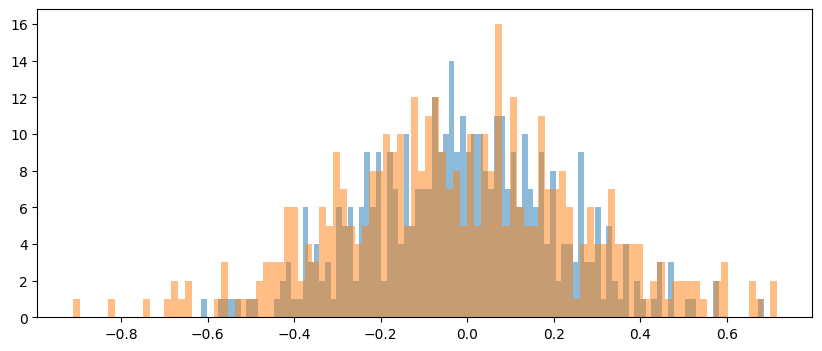

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(y, bins=100, alpha=0.5)
y = np.array(y) + noise * np.random.randn(N)
plt.hist(y, bins=100, alpha=0.5)
plt.show()

In [ ]:
pred_res = np.zeros(p * q)
for i in range(N):
  pred_res += X[i].reshape(-1, order='F') * y[i]
pred_res /= N

In [ ]:
theta_true_by_sigma = get_theta_by_sigma(X, y, lambd, sigma_true)

In [ ]:
theta_base, theta_modified, theta_modified_sum, sigma_base, sigma_modified, sigma_modified_sum = predict_theta(X, y, lambd, K_sum)

In [ ]:
print(np.linalg.norm(theta_base - theta_true))
print(np.linalg.norm(theta_modified - theta_true))
print(np.linalg.norm(theta_modified_sum - theta_true))
print(np.linalg.norm(theta_true_by_sigma - theta_true))

9.76026075346279
1.5053345653357428
1.7252222305635216
1.5738529968099029


In [ ]:
print(np.linalg.norm(sigma_base @ theta_true.reshape(-1, order='F') - pred_res))
print(np.linalg.norm(sigma_modified @ theta_true.reshape(-1, order='F') - pred_res))
print(np.linalg.norm(sigma_modified_sum @ theta_true.reshape(-1, order='F') - pred_res))
print(np.linalg.norm(sigma_true @ theta_true.reshape(-1, order='F') - pred_res))

0.03803342669161613
0.054539341206710314
0.05149474740915146
0.05310590812597693


In [ ]:
print(np.linalg.norm(sigma_base - sigma_true))
print(np.linalg.norm(sigma_modified - sigma_true))
print(np.linalg.norm(sigma_modified_sum - sigma_true))
print()
print(np.linalg.norm(sigma_modified_sum - sigma_base))

0.04889584874315405
0.009830636056766987
0.012082671013035874

0.047379894300184994


In [ ]:
cut_ind = 4
print(theta_true[:cut_ind, :cut_ind])
print(theta_base[:cut_ind, :cut_ind])
print(theta_modified[:cut_ind, :cut_ind])
print(theta_modified_sum[:cut_ind, :cut_ind])
print(theta_true_by_sigma[:cut_ind, :cut_ind])

[[-0.01369851 -0.05688434  0.04070332  0.04551991]
 [ 0.01487885 -0.0251487   0.03564746 -0.03687802]
 [ 0.03489061 -0.03758797 -0.01597575  0.00787051]
 [-0.03040698  0.00319801 -0.02405987  0.0295978 ]]
[[-0.16752593  0.03238246 -0.19500698 -0.17973577]
 [ 0.04550202 -0.14256723  0.28484158  0.28587188]
 [ 0.20302529  0.00212275 -0.01424712  0.26907641]
 [-0.089825    0.03565454 -0.0439146   0.22814473]]
[[-0.33482947  0.2798411  -0.21132825 -0.06766857]
 [ 0.16104188 -0.1853177   0.23695598  0.6444487 ]
 [-0.07859889  0.11174921 -0.0051743   0.35228287]
 [-0.16071836 -0.04192734 -0.00105438  0.33474837]]
[[-0.33622437  0.28680785 -0.21024551 -0.06033119]
 [ 0.15359498 -0.17612902  0.22820461  0.65587587]
 [-0.08435677  0.11660329 -0.00840219  0.34397226]
 [-0.16760647 -0.04423406  0.00197765  0.33189687]]
[[-0.33713513  0.26768172 -0.19868023 -0.08913813]
 [ 0.18693218 -0.2240185   0.24189791  0.60635137]
 [-0.0659513   0.09483598  0.00180883  0.33547692]
 [-0.13502596 -0.06053648  

In [ ]:
cut_ind = 4
print(sigma_true[:cut_ind, :cut_ind])
print(sigma_base[:cut_ind, :cut_ind])
print(sigma_modified[:cut_ind, :cut_ind])
print(sigma_modified_sum[:cut_ind, :cut_ind])

[[ 0.02449512  0.00238009 -0.00447988 -0.00068453]
 [ 0.00238009  0.02740309  0.00021556  0.00345423]
 [-0.00447988  0.00021556  0.02711156  0.00234473]
 [-0.00068453  0.00345423  0.00234473  0.02864432]]
[[ 0.02528629  0.00259991 -0.00481636  0.00058196]
 [ 0.00259991  0.02846066 -0.00172984  0.00326833]
 [-0.00481636 -0.00172984  0.02925241  0.00223021]
 [ 0.00058196  0.00326833  0.00223021  0.02632011]]
[[ 0.0239032   0.00287335 -0.00414965 -0.00093529]
 [ 0.00287335  0.02701519  0.00074748  0.00368279]
 [-0.00414965  0.00074748  0.02761865  0.00245648]
 [-0.00093529  0.00368279  0.00245648  0.0276756 ]]
[[ 0.02404669  0.00223713 -0.00460059 -0.00075556]
 [ 0.00223713  0.02679077  0.00024506  0.00270506]
 [-0.00460059  0.00024506  0.02650843  0.00192603]
 [-0.00075556  0.00270506  0.00192603  0.02676732]]


### Графики

[200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000]
Done: 200
Done: 300
Done: 400
Done: 500
Done: 600
Done: 700
Done: 800
Done: 900
Done: 1000
Done: 2000
Done: 3000
Done: 4000


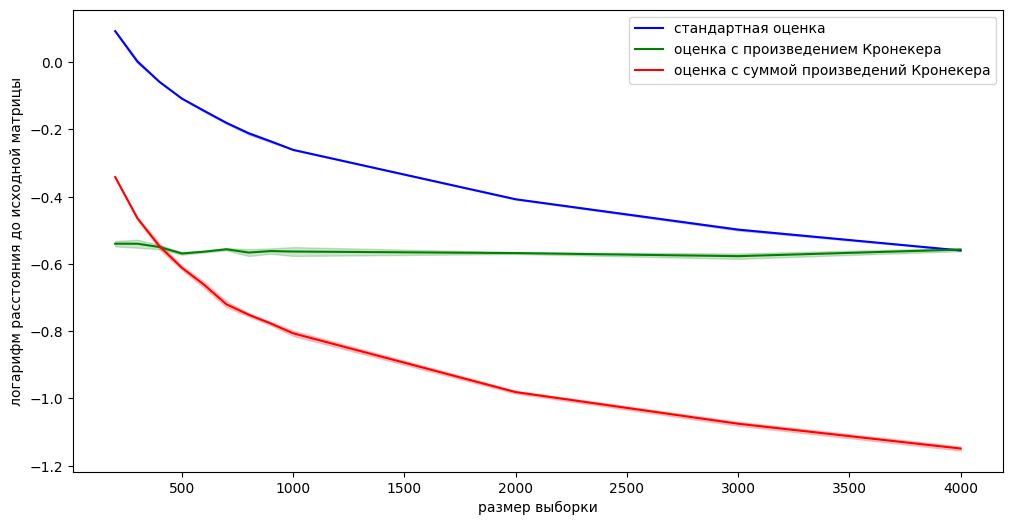

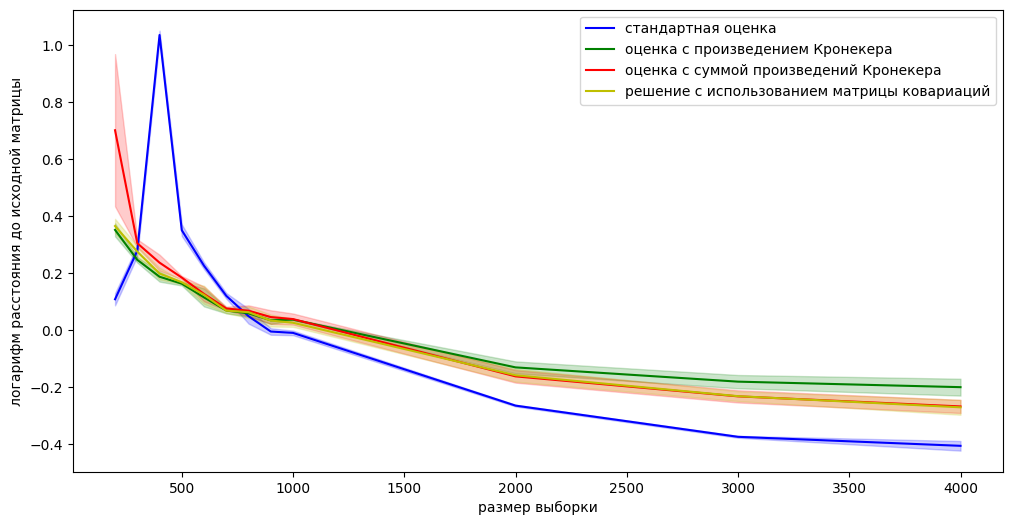

In [ ]:
import matplotlib.pyplot as plt

samples = 3
lambd = 10**-6
#N_coef_list = [1, 5] + list(range(10, 100 + 1, 20))
#delt = np.array([0.01, 0.05, 0.1, 0.15, 0.2])
#N_coef_list = (1.0 - delt).tolist()[::-1]  + [1.0] + (1.0 + delt).tolist()
N_coef_list = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000]
print(N_coef_list)

q = 20
p = 20
K_sum = 10
noise = 0.2


fro_norms = {
    "sigma": {},
    "theta": {}
}
N_cnt = len(N_coef_list)
for first_name in ["sigma", "theta"]:
    for second_name in ["zero", "base", "modified", "modified_sum"]:
      fro_norms[first_name][second_name] = np.zeros((N_cnt, samples))
fro_norms["theta"]["from_true_sigma"] = np.zeros((N_cnt, samples))

for N_ind, N_coef in enumerate(N_coef_list):
  for sample_ind in range(samples):
    N = N_coef
    X, y, theta_true, sigma_true = generate_reg_data(q, p, N, K_sum)
    y = np.array(y) + noise * np.random.randn(N)
    theta_base, theta_modified, theta_modified_sum, sigma_base, sigma_modified, sigma_modified_sum = predict_theta(X, y, lambd, K_sum)
    theta_from_true_sigma = get_theta_by_sigma(X, y, lambd, sigma_true)

    fro_norms["sigma"]["zero"][N_ind, sample_ind] = np.linalg.norm(sigma_true)
    fro_norms["sigma"]["base"][N_ind, sample_ind] = np.linalg.norm(sigma_base - sigma_true)
    fro_norms["sigma"]["modified"][N_ind, sample_ind] = np.linalg.norm(sigma_modified - sigma_true)
    fro_norms["sigma"]["modified_sum"][N_ind, sample_ind] = np.linalg.norm(sigma_modified_sum - sigma_true)

    fro_norms["theta"]["zero"][N_ind, sample_ind] = np.linalg.norm(theta_true)
    fro_norms["theta"]["base"][N_ind, sample_ind] = np.linalg.norm(theta_base - theta_true)
    fro_norms["theta"]["modified"][N_ind, sample_ind] = np.linalg.norm(theta_modified - theta_true)
    fro_norms["theta"]["modified_sum"][N_ind, sample_ind] = np.linalg.norm(theta_modified_sum - theta_true)
    fro_norms["theta"]["from_true_sigma"][N_ind, sample_ind] = np.linalg.norm(theta_from_true_sigma - theta_true)
  print("Done:", N_coef)

ind_mapper = {name:ind for ind, name in enumerate(["base", "modified", "modified_sum", "from_true_sigma", "zero"])}
plot_names = ["стандартная оценка", "оценка с произведением Кронекера", "оценка с суммой произведений Кронекера", "решение с использованием матрицы ковариаций", "норма исходной матрицы"]
plot_colors = ["b", "g", "r", "y"]

fig = plt.figure(figsize=(12, 6))
for plot_name in ["base", "modified", "modified_sum"]:
  plot_ind = ind_mapper[plot_name]
  arr = np.log10(fro_norms["sigma"][plot_name])
  mean_arr = np.mean(arr, axis=1)
  std_arr = np.std(arr, axis=1)
  plt.fill_between(N_coef_list, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2, color=plot_colors[plot_ind])
  plt.plot(N_coef_list, mean_arr, label=plot_names[plot_ind], color=plot_colors[plot_ind])

plt.ylabel("логарифм расстояния до исходной матрицы")
plt.xlabel("размер выборки")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12, 6))
for plot_name in ["base", "modified", "modified_sum", "from_true_sigma"]:
  plot_ind = ind_mapper[plot_name]
  arr = np.log10(fro_norms["theta"][plot_name])
  mean_arr = np.mean(arr, axis=1)
  std_arr = np.std(arr, axis=1)
  plt.fill_between(N_coef_list, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2, color=plot_colors[plot_ind])
  plt.plot(N_coef_list, mean_arr, label=plot_names[plot_ind], color=plot_colors[plot_ind])
  # np.clip(mean_arr - std_arr, a_min=0.0, a_max=None)

plt.ylabel("логарифм расстояния до исходной матрицы")
plt.xlabel("размер выборки")
plt.legend()
plt.show()

In [ ]:
fro_norms["sigma"]

{'zero': array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]),
 'base': array([[1.24253953, 1.23284213, 1.2351645 ],
        [1.01121594, 0.99074733, 1.01119029],
        [0.87375337, 0.87492711, 0.87000038],
        [0.78195034, 0.77789801, 0.77783647],
        [0.71746565, 0.71073129, 0.72090477],
        [0.65638916, 0.66426125, 0.65917859],
        [0.62000715, 0.60801614, 0.61554372],
        [0.58579104, 0.580005  , 0.57769846],
        [0.54874396, 0.5479125 , 0.54900429],
        [0.39129943, 0.38995814, 0.39218541],
        [0.3161572 , 0.32041878, 0.31665087],
        [0.27576032, 0.2752276 , 0.27552102]]),
 'modified': array([[0.29444693, 0.28162297, 0.28975048],
        [0.29407346, 0.27740443, 0.29428722],
        [0.28760646, 0.28057858, 0.27771654],
        [0.266

In [ ]:
fro_norms["theta"]

{'zero': array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]),
 'base': array([[ 1.23705273,  1.24082921,  1.37637926],
        [ 1.89634304,  2.00387474,  1.80161672],
        [10.73607935, 10.49750182, 11.4125108 ],
        [ 2.28544589,  2.10129628,  2.34712486],
        [ 1.62080909,  1.7269101 ,  1.70084569],
        [ 1.36194002,  1.29474067,  1.30123991],
        [ 1.02794211,  1.17471146,  1.15978656],
        [ 0.96935053,  0.97121678,  1.02566269],
        [ 1.00122108,  0.97421822,  0.95751199],
        [ 0.53852241,  0.54206386,  0.54805288],
        [ 0.42071428,  0.42619518,  0.41846143],
        [ 0.41402492,  0.37873141,  0.3846219 ]]),
 'modified': array([[2.37336448, 2.28578752, 2.09444379],
        [1.74960571, 1.82034619, 1.72653046],
        [1.5955345 , 1.4